# Michaelis-Menten type reaction

An important category of chemical reactions in biological systems is enzymatic reactions that follow [Michaelis-Menten kinetics](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics). MOOSE has builtin classes for modeling such reactions.

In [1]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose

In [2]:
# Containers
model = moose.Neutral('/model')
data = moose.Neutral('/data')
comp = moose.CubeMesh(f'{model.path}/comp')

In [3]:
subPool = moose.Pool(f'{comp.path}/S')  # pool of substrate molecules
prdPool = moose.Pool(f'{comp.path}/P')  # pool of product molecules
enzPool = moose.Pool(f'{comp.path}/E')  # pool of enzyme molecules
enz = moose.MMenz(f'{comp.path}/enz')  # Michaelis-Menten enzymatic reaction kinetics

In [4]:
moose.connect(enz, 'sub', subPool, 'reac')    # connect "sub" field of reac to the "reac" field of subPool
moose.connect(enz, 'prd', prdPool, 'reac')    # connect "sub" field of reac to the "reac" field of prdPool
moose.connect(enzPool, 'nOut', enz, 'enzDest')    # connect "nOut" field, the number of free molecules of enzPool to the "enzDest" field of MMenz object

<moose.SingleMsg id=5 dataIndex=2 path=/Msgs[0]/singleMsg[2]>

In [5]:
stoich = moose.Stoich(f'{comp.path}/stoich')
stoich.compartment = comp
ksolve = moose.Ksolve(f'{comp.path}/ksolve')
stoich.ksolve = ksolve
stoich.reacSystemPath = f'{comp.path}/##'

## Setup data recording

In [6]:
subTab = moose.Table2(f'{data.path}/S')
prdTab = moose.Table2(f'{data.path}/P')

In [7]:
moose.connect(subTab, 'requestOut', subPool, 'getConc')
moose.connect(prdTab, 'requestOut', prdPool, 'getConc')

<moose.SingleMsg id=5 dataIndex=5 path=/Msgs[0]/singleMsg[5]>

## Set the reaction kinetics properties

In [8]:
enz.Km = 1.0       # mmol/L
enz.kcat = 1e-2  # s^-1

## Set the initial conenctrations

In [9]:
enzPool.concInit = 0.1   # mmol/L
subPool.concInit = 1.25    # mmol/L
prdPool.concInit = 0.0   # mmol/L

## Initialize and run simulation

In [10]:
simtime = 1e4

moose.reinit()
moose.start(simtime)

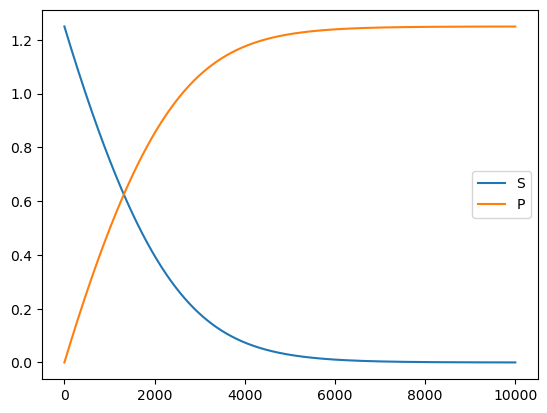

In [11]:
t = np.arange(len(subTab.vector)) * subTab.dt
plt.plot(t, subTab.vector, label='S')
plt.plot(t, prdTab.vector, label='P')
plt.legend()

## Repeating the experiment with different initial substrate concentration

Now that we have the basic Michaelis-Menten scheme working, we can try different initial concentrations of the substrate and try to make a Lineweaver-Burk plot. 

Lineweaver-Burk plot uses reaction rate at the initial concentration of the substrate. So we need to simulate only the early part of the reaction. Therefore we set the simulation time to 10 s. We create an array of $[S]_{0}$, the initial substrate concentration in `subList`, and reinitialize and run the simulation using these values to set the `concInit` field of `subPool`. After the simulation we calculate the reaction rate (with sign) as the ratio of the change in substrate concentration (`subPool.conc - initSubConc`) and the simulated time (`simtime`). Finally we collect this rate in the list `Vlist`.


In [12]:
simtime = 10.0   # We only simulate the first 10 s - short enough to approximate rate
subList = np.arange(1.0, 101.0, 1.0)   # Initial substrate concentrations to test
Vlist = []       # To collect the initial reaction rates

# Loop through the initial substrate concentrations and run the simulation
for initSubConc in subList:
    subPool.concInit = initSubConc    # mmol/L    
    moose.reinit()                # Reinitialize the model
    moose.start(simtime)          # Run the simulation
    V = (subPool.conc - initSubConc) / simtime     # Approximate reaction rate (change in substrate concentration / time)
    Vlist.append(V)

In the next step we take the absolute value of the reaction rate using `numpy.abs()` function. This also converts the list into a numpy array, which can be used in vectorized operations. If `Vlist` remained a list, `1/Vlist` would have thrown and error.


Theoretically, the x-intercept of the Lineweaver-Burk plot should be at $\frac{-1}{K_{M}}$, and the slope $\frac{K_{M}}{v_{max}}$. 

Here $v_{max} = K_{cat}\times {[E]_{0}}$ = 1e-2 * 0.1 = 1e-3. 

Since $K_{M} = 1.0$, slope should be 1.0/1e-3 = 1000.0.

Therefore, for the largest x ($=\frac{1}{[S]_{0}}$) the y value would be $1000 * (1/K_{M} + 1/min([S]_{0}))$. Since our array of initial concentrations `subList` is in ascending order, `subList[0]` is the smallest entry.


In [13]:
# Reaction rate is measured in abosolute value, this also converts
# the list into array so that we can take reciprocal in one go as a 
# vector operation
Vlist = np.abs(Vlist)      
v_max = enz.kcat * enzPool.concInit
slope = enz.Km / v_max
y_max =  slope * (1 / enz.Km + 1 / subList[0])

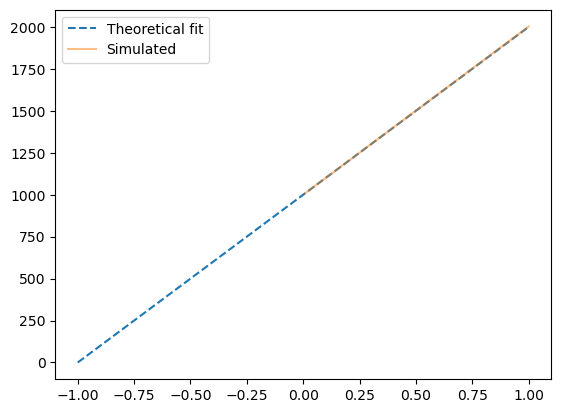

In [14]:
plt.plot([-1 / enz.Km, 1 / subList[0]], [0, y_max], '--', label='Theoretical fit')
plt.plot(1 / subList, 1 / Vlist, alpha=0.5, label='Simulated')
plt.legend()

## Exercise
TODO.